In [1]:
# Dependencies
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
# Classes
class State():
    def __init__(self, name):
        self.name = name
        self.final = False
        self.edges = []

    def add_edge(self, destiny, transition, output):
        edge = Edge(self.name, destiny, transition, output)
        self.edges.append(edge)

    def add_state_to_fst(self, fst):
        fst.add_node(self.name, final=self.final)

    def add_edges_to_fst(self, fst):
        for edge in self.edges:
            fst.add_edge(edge.origin, edge.destiny,
                         transition=edge.transition, output=edge.output)

    def set_final(self, is_final):
        self.final = is_final

    def is_equal(self, state):
        if self.final != state.final:
            return False
        if len(self.edges) != len(state.edges):
            return False
        for edge in self.edges:
            found_equivalent = False
            for state_edge in state.edges:
                if (edge.destiny == state_edge.destiny and edge.transition == state_edge.transition and edge.output == state_edge.output):
                    found_equivalent = True
                    break
            if found_equivalent:
                continue
            return False
        return True

    def transition(self, letter):
        for edge in self.edges:
            if (edge.transition == letter):
                return edge.destiny
        return None

    def output(self, letter):
        for edge in self.edges:
            if (edge.transition == letter):
                return edge.output
        return None

    def clear(self):
        self.final = False
        self.edges = []

    def copy(self):
        new_state = State(self.name)
        new_state.set_final(self.final)
        for edge in self.edges:
            new_state.add_edge(edge.destiny, edge.transition, edge.output)
        return new_state


class Edge():
    def __init__(self, origin, destiny, transition, output):
        self.origin = origin
        self.destiny = destiny
        self.transition = transition
        self.output = output


In [3]:
# Utils
def findMinimizedState(state, minimal_states):
    for frozen_state in minimal_states:
        if frozen_state.is_equal(state):
            return frozen_state
    minimal_states.append(state)
    return state

def findStateByLetter(letter, minimal_states):
    for frozen_state in minimal_states:
        if frozen_state.name == letter:
            return frozen_state
    return None

In [4]:
# Create Minimal Transducer
def create_minimal_transducer(dictionary):
    # Initial
    
    fst = nx.DiGraph()
    minimal_states = []
    


    # Algorithm

    state0 = State(0)
    state0.add_edge(1,'a',1)
    state0.add_edge(2,'b',3)
    state1 = State(1)
    state1.add_edge(2,'b',4)
    state2 = State(2)
    state2.set_final(True)

    minimal_states.append(state0)
    minimal_states.append(state1)
    minimal_states.append(state2)

    # for word, index in dictionary.items():
    #     pass

    # Creating FST based on list

    for state in minimal_states:
        state.add_state_to_fst(fst)
    for state in minimal_states:
        state.add_edges_to_fst(fst)
    return fst

In [5]:
# Create Dictionary
def create_dictionary():
    dictionary = {"jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6,
                  "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12}
    dictionary = dict(sorted(dictionary.items()))
    return dictionary


In [6]:
# Read Input

def read_input(input, fst):
    state = 0
    output = 0
    for letter in input:
        current_state_edges = dict(fst[state])
        prev_state = state
        for next_state, edge_properties in current_state_edges.items():
            if edge_properties['transition'] == letter:
                state = next_state
                output += edge_properties['output']
                break
        if (state == prev_state):
            break
    return output


1


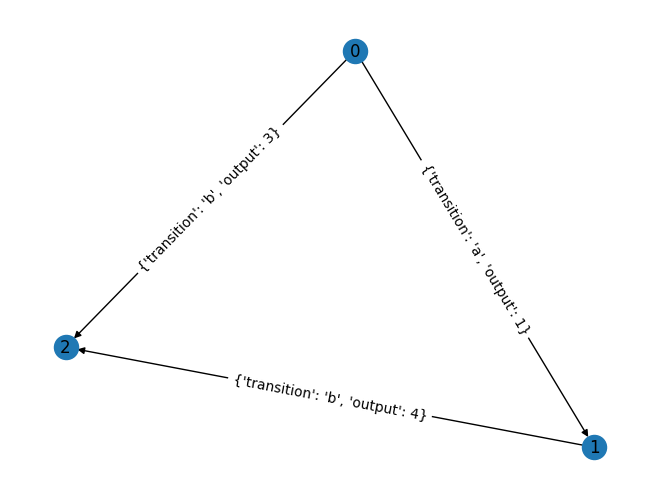

In [7]:
# Main

dictionary = create_dictionary()
fst = create_minimal_transducer(dictionary)
pos = nx.spring_layout(fst)
plt.figure()
nx.draw(fst, pos, with_labels=True)
nx.draw_networkx_edge_labels(fst, pos)

print(read_input("aaa", fst)) 
